In [1]:
# For now, I'm just focusing on delta hedging. After that is done, we make a system of equations
# to set delta and vega to 0 and solve with np.linalg.solve() (see examples/ex6sol for reference).
# %pip install pyfinance
# %pip install py_vollib
# %pip install pandas
# %pip install matplotlib

import pandas as pd
from pyfinance.options import BSM
from datetime import datetime, timedelta
import py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt

df = pd.read_csv("../data/apple.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df['date'] = pd.to_datetime(df['Date'])
df['T'] = (pd.to_datetime('2024-01-19') - df['date']).dt.days / 252 # T = time to expiration in years, 252 trading days
df = df.drop(["date"], axis=1)
df.head()

#interest rate data
df2 = pd.read_csv('../code/csv-data/daily-treasury-rates.csv')
df2 = df2[['Date', '13 WEEKS COUPON EQUIVALENT']]
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%Y')
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')
df2 = df2[df2['Date'] >= '2023-08-21']
df2['13 WEEKS COUPON EQUIVALENT'] = df2['13 WEEKS COUPON EQUIVALENT'] / 100
df_result = pd.merge(df, df2, on='Date', how='left')
df_result.rename({"13 WEEKS COUPON EQUIVALENT": "Interest rate"}, axis="columns", inplace=True)
df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)
df_result.head()

,Date,Underlying,C170,C175,C180,C185,C190,P170,P175,P180,P185,P190,T,Interest rate
0,2023-08-21,175.84,16.40,13.27,10.30,7.85,5.91,6.81,8.65,10.85,13.35,16.50,0.599206,0.0546
1,2023-08-22,177.23,17.50,14.10,11.10,8.51,6.34,6.26,8.10,10.10,12.75,15.50,0.595238,0.0546
2,2023-08-23,181.12,20.20,16.65,13.45,10.55,8.08,5.25,6.71,8.50,10.70,13.33,0.591270,0.0546
3,2023-08-24,176.38,16.97,13.75,10.80,8.35,6.25,6.85,8.62,10.75,13.35,16.60,0.587302,0.0547
4,2023-08-25,178.61,18.50,15.15,11.85,9.19,6.90,5.90,7.50,9.50,11.90,14.81,0.583333,0.0550


The delta measures the rate of change of the security wrt. to the price of the underlying. Thus, the delta of the stock is one.
Vega measures the rate of change of the security wrt. to the volatility of the underlying. Again, the vega of the stock is one. In delta hedging, we short the option and hold a dynamically adjusted amount of the risky asset to eliminate the risk.

Next, calculate the hedge with 2 portfolios: OP and RE. OP has a long call and RE has a short amount of the underlying asset (here, $AAPL). We want P = OP + RE to be neutral to small changes in the underlying price.

# Delta hedging a single option

In [2]:
# The code below is bit of spaghetti code and could use some significant improvements when time available
# TODO:
# - give all necessary information (option amounts, strikes, option types, etc.) as a parameter
# - handle printing in its own function
# - save and show the data in a clearer format
def delta_hedge(call_option_prices, freq, colname):
    # call_options_oruces is a df, freq is hedging frequency (e.g. 30 = once a month), colname is e.g. "C170"
    # This has been looked up from the internet for Apple stock option
    option_amount = 1000
    interest_rate = call_option_prices.iloc[0]['Interest rate']
    option_type = 'call' if colname[0] == "C" else "put"
    stock_price = call_option_prices.iloc[0]['Underlying']
    option_price = call_option_prices.iloc[0][colname]
    strike = int(colname[1:])
    time_to_maturity = call_option_prices.iloc[0]['T']
    volatility = implied_volatility(price=option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag=option_type[0])
    
    # Initial stuff at t = 0
    bsm_obj = BSM(kind=option_type, S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=volatility)
    OP = bsm_obj.value() * option_amount # Value of the option according to BSM from the assignment
    delta = bsm_obj.delta()
    RE = - delta * stock_price * option_amount # Replicating portfolio from the assignment

    print("================ Initial values: =================")
    print("Date:", call_option_prices.iloc[0]['Date'])
    print(f"Value of single call option (for {option_amount} stocks) according to BSM: ", round(OP, 2))
    print("Value of the short position according to BSM: ", round(RE, 2))
    print("Delta of the option according to BSM: ", round(delta, 2))
    print('==================================================')
    print('\n')

    # We will keep track of the changes in the portfolios
    # This corresponds to the do we make loss or profit in hedging
    total_mean_squared_error = []
    
    # next we calculate changes in OP and RE and let A_0 = d OP - d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(call_option_prices)-1):
        new_OP = call_option_prices[colname][i] * option_amount
        new_RE = - delta * call_option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        a_0 = d_OP + d_RE # changed - to +. We would want this to be 0; IMMUNE TO CHANGES
        total_mean_squared_error.append(a_0**2)

        print('=================================================')
        print("Date:", call_option_prices['Date'][i])
        print(f"Value of single call option (for {option_amount} stocks) according to BSM: ", round(new_OP, 2))
        print("Value of the new short position according to BSM: ", round(new_RE, 2))
        print("Difference of the long positions: ", round(d_OP))
        print("Difference of the short positions: ", round(d_RE))
        print("Delta of the option according to BSM: ", round(delta, 2))
        print("Total error, difference of the portfolios: ", round(a_0, 2))
        print('=================================================')
        print('\n')

        OP = new_OP
        RE = new_RE

        # Rehedging happens here
        # every second day, t2, t4, t6, so on..
        # Change the modulo for different intervals, 1 = every day, 30 = every month and so on
        if i % freq == 0:
            # Delta and volatility will be updated when we rehedge
            # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
            # In a real world scenario this hedging costs money, and will be simulated if we have time also in this
            delta = BSM(kind=option_type, S0=call_option_prices['Underlying'][i], K=strike, T=call_option_prices['T'][i], r=call_option_prices['Interest rate'][i], sigma=volatility).delta()
            volatility = BSM(kind=option_type, S0=call_option_prices['Underlying'][i], K=strike, T=call_option_prices['T'][i], r=call_option_prices['Interest rate'][i], sigma=volatility).implied_vol(call_option_prices[colname][i])

            print('=============== REHEDGE =========================')
            print("Rehedging date:", call_option_prices['Date'][i])
            print("Delta updated, new delta is:", round(delta, 2))
            print("Volatility updated, new implied volatility is:", round(volatility, 5))
            print('To delta-hedge a single long call option, we need to readjust the RE:')

            # We have to solve a linear equation, where the delta of the portfolio is zero
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -(delta * call_option_prices['Underlying'][i] * option_amount)
            # or just the amount
            amount = -(delta * option_amount)

            if amount > 0:
                print('Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount))
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount))
            else:
                print('Portfolio is in balance, no need for readjustment')
            print('Long position is: ', round(OP))
            print('=============== REHEDGE ENDS ====================')
            print('\n')

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1] # Sum 1 to n-1 of the MSEs
    total_error *= (1 / (len(total_mean_squared_error)-1) )
    print('========== Total Mean Squared Error ==============')
    print("The total mean squared error is : ", total_error)
    print('==================================================')

    return total_mean_squared_error, total_error # return daily errors and the total error for plotting purposes
    

================ Initial values: =================
Date: 2023-08-21
Value of single call option (for 1000 stocks) according to BSM:  16400.0
Value of the short position according to BSM:  -123781.57
Delta of the option according to BSM:  0.7


Date: 2023-08-22
Value of single call option (for 1000 stocks) according to BSM:  17500.0
Value of the new short position according to BSM:  -124760.05
Difference of the long positions:  1100
Difference of the short positions:  -978
Delta of the option according to BSM:  0.7
Total error, difference of the portfolios:  121.52


=============== REHEDGE =========================
Rehedging date: 2023-08-22
Delta updated, new delta is: 0.72
Volatility updated, new implied volatility is: 0.18856
To delta-hedge a single long call option, we need to readjust the RE:
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  723
Long position is:  17500
=============== REHEDGE ENDS ====================


Date: 2023-08-23

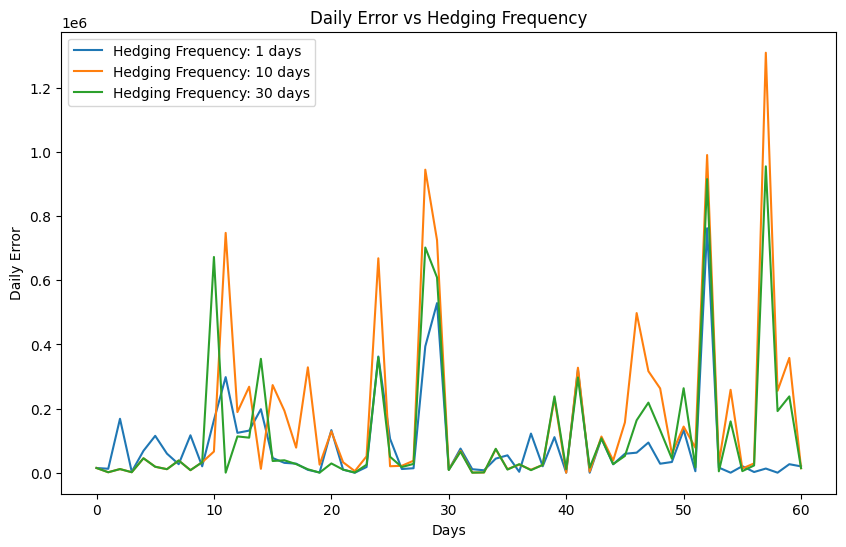

In [3]:
hedging_frequencies = [1, 10, 30]
plt.figure(figsize=(10, 6))
for freq in hedging_frequencies:
    total_mean_squared_error, _ = delta_hedge(df_result, freq, "C170")
    plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')

plt.xlabel('Days')
plt.ylabel('Daily Error')
plt.title('Daily Error vs Hedging Frequency')
plt.legend()
plt.show()


================ Initial values: =================
Date: 2023-08-21
Value of single call option (for 1000 stocks) according to BSM:  16400.0
Value of the short position according to BSM:  -123781.57
Delta of the option according to BSM:  0.7


Date: 2023-08-22
Value of single call option (for 1000 stocks) according to BSM:  17500.0
Value of the new short position according to BSM:  -124760.05
Difference of the long positions:  1100
Difference of the short positions:  -978
Delta of the option according to BSM:  0.7
Total error, difference of the portfolios:  121.52


=============== REHEDGE =========================
Rehedging date: 2023-08-22
Delta updated, new delta is: 0.72
Volatility updated, new implied volatility is: 0.18856
To delta-hedge a single long call option, we need to readjust the RE:
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  723
Long position is:  17500
=============== REHEDGE ENDS ====================


Date: 2023-08-23

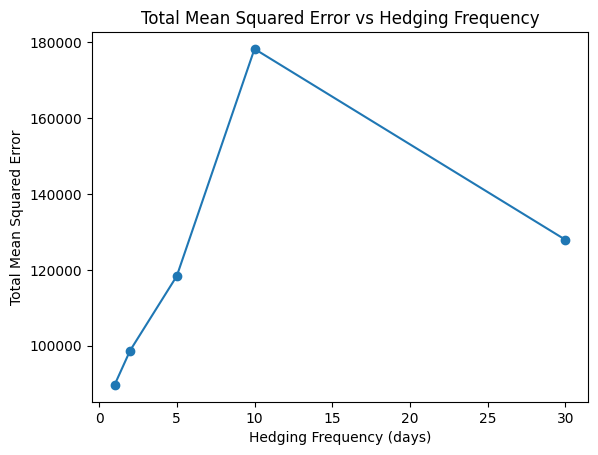

In [10]:
hedging_frequencies = [1, 2, 5, 10, 30]

results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error = delta_hedge(df_result, freq, "C170")
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

# Plotting
plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()

# Delta hedging a Straddle option strategy

A Straddle is a combination option trading strategy. Straddle consists of 1 call option and 1 put option, with the same strike price and maturity of the same underlying stock. The idea of making profit using Straddle is that the investor expects the underlying to go to a sharp direction, either up or down.

In [18]:
# TODO: Copy-paste spaghetti, refactor when time
# - Give stuff as parameter instead of declaring the in the function
# - Printing to its own function/module
def delta_hedge_straddle(option_prices):
    # Apple stock is sold in 1000 pcs units
    # Lets assume that the amount is same for put and call options
    # Not sure if they can be different, like 800 puts and 1000 calls
    option_amount = 1000

    # 3-Month Treasury Yield taken on a daily basis regarding our hedging interval
    interest_rate = option_prices.iloc[0]['Interest rate'] 
    stock_price = option_prices.iloc[0]['Underlying']

    # Adjust here the call and put prices for your liking
    # STRADDLE = Same option with same strikes and maturity, put both call and put options
    call_option_price = option_prices.iloc[0]['C180']
    put_option_price = option_prices.iloc[0]['P180']
    strike = 180
    
    time_to_maturity = option_prices.iloc[0]['T']
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag='p')
    
    # Initial stuff at t = 0
    call_bsm = BSM(kind='call', S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=call_volatility)
    put_bsm = BSM(kind='put', S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=put_volatility)

    # Forming the straddle portfolio
    put_delta = put_bsm.delta()
    call_delta = call_bsm.delta()

    # Long position consists of both of the option values
    OP = call_bsm.value() * option_amount + put_bsm.value() * option_amount

    # Short position, the replicating portfolio, consists of the call and put delta amounts of the underlying 
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount

    # Combined delta of the options
    combined_delta = call_delta + put_delta

    print("================ Initial values: =================")
    print("Date:", option_prices.iloc[0]['Date'])
    print("Value of long Straddle portfolio: ", round(OP, 4))
    print('Call delta: ', round(call_delta, 4))
    print('Put delta: ', round(put_delta, 4))
    print("Value of the delta of the Straddle (call delta + put delta): ", round(combined_delta, 4))
    print("Value of the short Straddle portfolio: ", round(RE, 4))
    print('==================================================')
    print('\n')

    # Keep track of the mean squared error values, which means changes in the portfolios
    # This corresponds to the do we make loss or profit in hedging
    total_mean_squared_error = []
    
    # Next we calculate changes in OP and RE and let A_0 = d OP - d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(option_prices)-1, 1):
        new_call_bsm_obj = BSM(kind='call', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility)
        new_put_bsm_obj = BSM(kind='put', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility)
        new_OP = new_call_bsm_obj.value() * option_amount + new_put_bsm_obj.value() * option_amount
        new_RE = -combined_delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = combined_delta * (option_prices['Underlying'][i+1] - option_prices['Underlying'][i]) * option_amount
        a_0 = d_OP - d_RE
        total_mean_squared_error.append(a_0**2)

        print('=================================================')
        print("Date:", option_prices['Date'][i])
        print("Value of Straddle position: ", round(new_OP, 2))
        print("Value of the delta of the Straddle position: ", round(combined_delta, 2))
        print("Value of the new short position according to BSM: ", round(new_RE, 2))
        print("Difference of the long positions: ", round(OP - new_OP))
        print("Difference of the short positions: ", round(RE - new_RE))
        print("A_0, total error, difference of the portfolios: ", a_0)
        print('=================================================')
        print('\n')

        OP = new_OP
        RE = new_RE

        # Rehedging happens here
        # every second day, t2, t4, t6, so on..
        # Change the modulo for different intervals, 1 = every day, 30 = every month and so on
        # Delta and volatility will be updated when we rehedge
        # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
        # In a real world scenario this hedging costs money, and will be simulated if we have time also in this
        if i % 30 == 0:
            put_delta = new_put_bsm_obj.delta()
            call_delta= new_call_bsm_obj.delta()
            combined_delta =  put_delta + call_delta
            call_volatility = BSM(kind='call', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility).implied_vol(option_prices['C180'][i])
            put_volatility = BSM(kind='put', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility).implied_vol(option_prices['P180'][i])

            print('=============== REHEDGE =========================')
            print("Rehedging date:", option_prices['Date'][i])
            print("Combined Delta updated, new combined Delta is:", round(combined_delta, 4))
            print("Call Delta updated, new Call Delta is:", round(call_delta, 4))
            print("Put Delta updated, new Put Delta is:", round(put_delta, 4))
            print("Volatilities updated, new implied volatility for call option is:", round(call_volatility, 5))
            print("Volatilities updated, new implied volatility for put option is:", round(put_volatility, 5))
            print('To delta-hedge the Straddle position, we need to readjust the RE:')
            
            # We have to solve a linear equation, where the delta of the portfolio is zero
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -combined_delta * option_prices['Underlying'][i] * option_amount
            
            # Option_amount is the amount of options
            amount = -(combined_delta * option_amount)
            if amount > 0:
                print('Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount, 4))
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount, 4))
            else:
                print('Portfolio is in balance, no need for readjustment')
            print('Long position is: ', round(OP))
            print('=============== REHEDGE ENDS ====================')
            print('\n')
        
    # Count the total error
    # Determines did we make profit or loss
    total_error = 0
    for i in range(0, len(total_mean_squared_error)-1):
        total_error += total_mean_squared_error[i]
    total_error = total_error*(1/(len(total_mean_squared_error)-1))
    print('========== Total Mean Squared Error ==============')
    print("The total mean squared error is : ", total_error)
    print('==================================================')

In [6]:
delta_hedge_straddle(df_result)

================ Initial values: =================
Date: 2023-08-21
Value of long Straddle portfolio:  19516.2922
Call delta:  0.5543
Put delta:  -0.4456
Value of the delta of the Straddle (call delta + put delta):  0.1087
Value of the short Straddle portfolio:  -175828.817


Date: 2023-08-22
Value of Straddle position:  19632.57
Value of the delta of the Straddle position:  0.11
Value of the new short position according to BSM:  -19273.04
Difference of the long positions:  -116
Difference of the short positions:  -156556
A_0, total error, difference of the portfolios:  -306.7449807374711


Date: 2023-08-23
Value of Straddle position:  20390.85
Value of the delta of the Straddle position:  0.11
Value of the new short position according to BSM:  -19696.06
Difference of the long positions:  -758
Difference of the short positions:  423
A_0, total error, difference of the portfolios:  1273.7378482677414


Date: 2023-08-24
Value of Straddle position:  19384.56
Value of the delta of the Stra

# Delta hedging a strangle option strategy

Strangle is another option strategy, which involves purchasing or selling two options of the same underlying. In a Strangle an investor buys a put and a call of the same underlying with the same maturities, but this time the strike prices will be different. The way to make profit is the same as in Strangle, that the investor expects the market to be volatile and move sharp to some direction, either up or down. The difference to Straddle is that the stock price has to move farther in Strangle to make profit.

In our long strangle, we buy an OTM call and an OTM put.

In [16]:
# TODO: Copy-paste spaghetti, refactor when time
# - Give stuff as parameter instead of declaring the in the function
# - Printing to its own function/module
def delta_hedge_strangle(option_prices):
    # Apple stock is sold in 1000 pcs units
    # Lets assume that the amount is same for put and call options
    # Not sure if they can be different, like 800 puts and 1000 calls
    option_amount = 1000

    # 3-Month Treasury Yield taken on a daily basis regarding our hedging interval
    interest_rate = option_prices.iloc[0]['Interest rate']
    stock_price = option_prices.iloc[0]['Underlying']

    # Adjust here the call and put prices for your liking
    # STRANGLE = Same option, same maturities, but both call and put which have different strikes
    call_option_price = option_prices.iloc[0]['C180']
    put_option_price = option_prices.iloc[0]['P175']
    put_strike = 175
    call_strike = 180
    
    time_to_maturity = option_prices.iloc[0]['T']
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='c')
    
    # Initial stuff at t = 0
    call_bsm = BSM(kind='call', S0=stock_price, K=call_strike, T=time_to_maturity, r=interest_rate, sigma=call_volatility)
    put_bsm = BSM(kind='put', S0=stock_price, K=put_strike, T=time_to_maturity, r=interest_rate, sigma=put_volatility)

    # Forming the straddle portfolio
    put_delta = put_bsm.delta()
    call_delta = call_bsm.delta()

    # Long position consists of both of the option values
    OP = call_bsm.value() * option_amount + put_bsm.value() * option_amount

    # Short position, the replicating protfolio, consists of the call and put delta amounts of the underlying 
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount

    # Combined delta of the options
    combined_delta = call_delta + put_delta

    print("================ Initial values: =================")
    print("Date:", option_prices.iloc[0]['Date'])
    print("Value of long Straddle portfolio: ", round(OP, 4))
    print('Call delta: ', round(call_delta, 4))
    print('Put delta: ', round(put_delta, 4))
    print("Value of the delta of the Strangle (call delta + put delta): ", round(combined_delta, 4))
    print("Value of the short Strangle portfolio: ", round(RE, 4))
    print('==================================================')
    print('\n')

    # Keep track of the mean squared error values, which means changes in the portfolios
    # This corresponds to the do we make loss or profit in hedging
    total_mean_squared_error = []
    
    # Next we calculate changes in OP and RE and let A_0 = d OP - d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(option_prices)-1, 1):
        new_call_bsm_obj = BSM(kind='call', S0=option_prices['Underlying'][i], K=call_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility)
        new_put_bsm_obj = BSM(kind='put', S0=option_prices['Underlying'][i], K=put_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility)
        new_OP = new_call_bsm_obj.value() * option_amount + new_put_bsm_obj.value() * option_amount
        new_RE = -combined_delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = combined_delta * (option_prices['Underlying'][i+1] - option_prices['Underlying'][i]) * option_amount
        a_0 = d_OP - d_RE
        total_mean_squared_error.append(a_0**2)

        print('=================================================')
        print("Date:", option_prices['Date'][i])
        print("Value of Strangle position: ", round(new_OP, 2))
        print("Value of the delta of the Strangle position: ", round(combined_delta, 2))
        print("Value of the new short position according to BSM: ", round(new_RE, 2))
        print("Difference of the long positions: ", round(OP - new_OP))
        print("Difference of the short positions: ", round(RE - new_RE))
        print("A_0, total error, difference of the portfolios: ", a_0)
        print('=================================================')
        print('\n')

        OP = new_OP
        RE = new_RE

        # Rehedging happens here
        # every second day, t2, t4, t6, so on..
        # Change the modulo for different intervals, 1 = every day, 30 = every month and so on
        # Delta and volatility will be updated when we rehedge
        # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
        # In a real world scenario this hedging costs money, and will be simulated if we have time also in this
        if i % 2 == 0:
            put_delta = new_put_bsm_obj.delta()
            call_delta= new_call_bsm_obj.delta()
            combined_delta =  put_delta + call_delta
            call_volatility = BSM(kind='call', S0=option_prices['Underlying'][i], K=call_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility).implied_vol(option_prices['C180'][i])
            put_volatility = BSM(kind='put', S0=option_prices['Underlying'][i], K=put_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility).implied_vol(option_prices['P175'][i])

            print('=============== REHEDGE =========================')
            print("Rehedging date:", option_prices['Date'][i])
            print("Combined Delta updated, new combined Delta is:", round(combined_delta, 4))
            print("Call Delta updated, new Call Delta is:", round(call_delta, 4))
            print("Put Delta updated, new Put Delta is:", round(put_delta, 4))
            print("Volatilities updated, new implied volatility for call option is:", round(call_volatility, 5))
            print("Volatilities updated, new implied volatility for put option is:", round(put_volatility, 5))
            print('To delta-hedge the Strangle position, we need to readjust the RE:')
            
            # We have to solve a linear equation, where the delta of the portfolio is zero
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -combined_delta * option_prices['Underlying'][i] * option_amount
            
            # 1 = for the amount of options
            amount = -(combined_delta * option_amount)
            if amount > 0:
                print('Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount, 4))
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount, 4))
            else:
                print('Portfolio is in balance, no need for readjustment')
            print('Long position is: ', round(OP))
            print('=============== REHEDGE ENDS ====================')
            print('\n')
        
    # Count the total error
    # Determines did we make profit or loss
    total_error = 0
    for i in range(0, len(total_mean_squared_error)-1):
        total_error += total_mean_squared_error[i]
    total_error = total_error*(1/(len(total_mean_squared_error)-1))
    print('========== Total Mean Squared Error ==============')
    print("The total mean squared error is : ", total_error)
    print('==================================================')

In [17]:
delta_hedge_strangle(df_result)

================ Initial values: =================
Date: 2023-08-21
Value of long Straddle portfolio:  12477.2285
Call delta:  0.5543
Put delta:  -0.2807
Value of the delta of the Strangle (call delta + put delta):  0.2736
Value of the short Strangle portfolio:  -146836.3742


Date: 2023-08-22
Value of Strangle position:  12845.92
Value of the delta of the Strangle position:  0.27
Value of the new short position according to BSM:  -48494.67
Difference of the long positions:  -369
Difference of the short positions:  -98342
A_0, total error, difference of the portfolios:  -695.712236254974


Date: 2023-08-23
Value of Strangle position:  14385.11
Value of the delta of the Strangle position:  0.27
Value of the new short position according to BSM:  -49559.07
Difference of the long positions:  -1539
Difference of the short positions:  1064
A_0, total error, difference of the portfolios:  2836.173122899496


=============== REHEDGE =========================
Rehedging date: 2023-08-23
Combined

ValueError: cannot convert float NaN to integer